# Basics of Python GPU programming


We are going to explore some Python GPU tools before getting started with the deep-learning example.
This is going to be more practical examples rather than an in-depth study because GPU programming is a topic for a separate course.

## Set up environment

I assume the commands which go before starting the notebook are read from the github page:

```bash
module load anaconda-graphlab/2.4.0
conda create -n GPU_env --clone=/usr/licensed/anaconda/graphlab/2.4.0
source activate GPU_env
module load cudatoolkit/7.0
conda install --name GPU_env numba
conda install --name GPU_env numbapro
conda update numbapro 
pip install --user pycuda
pip install --user -r requirements.txt
```

# Start the notebook

```bash
ipython notebook --ip=127.0.0.1
```

Let us set up our running example - vector addition.

In [6]:
import numpy as np
from timeit import default_timer as timer

def VectorAdd(a,b,c):
    for i in xrange(a.size):
        c[i] = a[i] + b[i]
   
N = 32000000

A = np.ones(N, dtype = np.float32)
B = np.ones(N, dtype = np.float32)
C = np.zeros(N, dtype = np.float32)

start = timer()
VectorAdd(A,B,C)
vectoradd_time = timer() - start

print("C[:5] = "+str(C[:5]))
print("C[-5:] = "+str(C[-5:]))

print("VectorAdd took %f seconds"%vectoradd_time)

C[:5] = [ 2.  2.  2.  2.  2.]
C[-5:] = [ 2.  2.  2.  2.  2.]
VectorAdd took 10.639884 seconds


# PyCUDA vectorize decorator



In [7]:
import numpy as np
from timeit import default_timer as timer
from numbapro import vectorize

@vectorize(["float32(float32,float32)"],target="gpu")
def VectorAdd(a,b):
    return a + b

N = 32000000

A = np.ones(N, dtype = np.float32)
B = np.ones(N, dtype = np.float32)
C = np.zeros(N, dtype = np.float32)

start = timer()
VectorAdd(A,B,C)
vectoradd_time = timer() - start

print("C[:5] = "+str(C[:5]))
print("C[-5:] = "+str(C[-5:]))

print("VectorAdd took %f seconds"%vectoradd_time)

C[:5] = [ 0.  0.  0.  0.  0.]
C[-5:] = [ 0.  0.  0.  0.  0.]
VectorAdd took 0.201960 seconds


# GPU (numpy) arrays

https://documen.tician.de/pycuda/array.html

All of CUDA’s supported vector types, such as float3 and long4 are available as numpy data types within this class. These numpy.dtype instances have field names of x, y, z, and w just like their CUDA counterparts. They will work both for parameter passing to kernels as well as for passing data back and forth between kernels and Python code. For each type, a make_type function is also provided (e.g. make_float3(x,y,z)).



In [8]:
import pycuda.gpuarray as gpuarray
import pycuda.autoinit
#from skcuda import linalg
#import misc
#linalg.init()

@vectorize(["float32(float32,float32)"],target="gpu")
def VectorAdd(a,b):
    return a + b

N = 32000000

A = np.ones(N, dtype = np.float32)
B = np.ones(N, dtype = np.float32)
C = np.zeros(N, dtype = np.float32)

A_gpu = gpuarray.to_gpu(A)
B_gpu = gpuarray.to_gpu(B)
C_gpu = gpuarray.to_gpu(C)

start = timer()
VectorAdd(A,B,C)
vectoradd_time = timer() - start

print("C[:5] = "+str(C[:5]))
print("C[-5:] = "+str(C[-5:]))

print("VectorAdd took %f seconds"%vectoradd_time)

C[:5] = [ 0.  0.  0.  0.  0.]
C[-5:] = [ 0.  0.  0.  0.  0.]
VectorAdd took 0.175240 seconds


# Facial key points detection with deep-learning

## Prerequisites


I am going to run this as a demo, but if you would like to repeat this offline, you would need to have access to a CUDA-capable GPU, CUDA toolkit, **Python 2.7.x**, numpy, pandas, matplotlib, and scikit-learn installed. 

Lasagne is a deep-learning library implemented in Python making use of a popular Theano package, is going to be installed from source on Github. To install Lasagne and all the remaining dependencies, run this command:


## Data

Navigate to the following page:
https://www.kaggle.com/c/facial-keypoints-detection


Navigate to the "Data" tab in the left menu, register, and donwload the data (yes, you would have to register), I cannot distribute these data freely:

<img src="kaggle_data.png">

The training dataset for the Facial Keypoint Detection challenge consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn the correct position (the x and y coordinates) of 15 keypoints, such as **left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip**, and so on.


<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/3486/media/face1_with_keypoints.png">
An example of one of the faces with three keypoints marked.

Note, that the dataset has missing data which results in the fact that for some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training. For the demo, I will simply drop the NANs... 

Below is an example Python code that loads the data from the CSV files provided on the Kaggle.com page. We'll write a function that can load both the training and the test data. These two datasets differ in that the test data doesn't contain the target values; it's the goal of the challenge to predict these. 

Here's our **load()** function:

In [1]:
import os

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle


FTRAIN = '/scratch/alexeys/data/training.csv'
FTEST = '/scratch/alexeys/data/test.csv'


def load(test=False, cols=None):
    """Loads data from FTEST if *test* is True, otherwise from FTRAIN.
    Pass a list of *cols* if you're only interested in a subset of the
    target columns.
    """
    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]

    print(df.count())  # prints the number of values for each column
    df = df.dropna()  # drop all rows that have missing values in them

    X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X, y


X, y = load()
print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

It is printing a list of all columns in the CSV file along with the number of available values for each. So while we have an Image for all rows in the training data, we only have 2,267 values for **mouth_right_corner_x** and so on.

load() returns a tuple (X, y) where y is the target matrix. y has shape **n x m** with n being the number of samples in the dataset that have all m keypoints. Dropping all rows with missing values is what this line does (this is wasteful!, but a good starting point):

```python
# drop all rows that have missing values in them
df = df.dropna()
```

### Risk of overfitting when training on a small dataset (after dropping NANs)
The script's output y.shape == (2140, 30) tells us that there's only 2,140 images in the dataset that have all 30 target values present. Initially, we'll train with these 2,140 samples only. Which leaves us with many more input dimensions (9,216) than samples; an indicator that overfitting might become a problem. 

It's a bad idea to throw away 70% of the training data just like that, and we'll talk about this later on.

Another feature of the load() function is that it scales the intensity values of the image pixels to be in the interval [0, 1], instead of 0 to 255. The target values (x and y coordinates) are scaled to [-1, 1]; before they were between 0 to 95.

## First model: a single hidden layer

Now that we're done with loading the data, let's use **Lasagne** and create a neural net with a single hidden layer. Here is the code:

In [2]:
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet

net1 = NeuralNet(
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values

    # optimization method:
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.9,

    regression=True,  # flag to indicate we're dealing with regression problem
    max_epochs=400,  # we want to train this many epochs
    verbose=1,
    )

X, y = load()
net1.fit(X, y)

Using gpu device 0: Tesla K20m
/home/alexeys/PythonCourseAddition/src/lasagne/lasagne/init.py:86: UserWarning: The uniform initializer no longer uses Glorot et al.'s approach to determine the bounds, but defaults to the range (-0.01, 0.01) instead. Please use the new GlorotUniform initializer to get the old behavior. GlorotUniform is now the default for all layers.
  warnings.warn("The uniform initializer no longer uses Glorot et al.'s "


left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

NeuralNet(X_tensor_type=<function matrix at 0x2b9aedf2e1b8>,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x2b9afecc2c10>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x2b9afecc2810>,
     custom_score=None, eval_size=0.2, hidden_num_units=100,
     input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=400, more_params={},
     objective=<class 'lasagne.objectives.Objective'>,
     objective_loss_function=<function mse at 0x2b9afdfdb8c0>,
     on_epoch_finished=[<nolearn.lasagne.util.PrintLog instance at 0x2b9aeb669998>],
     on_training_finished=[], output_nonlinearity=None,
     output_num_units=30, regression=True,
     update=<function nesterov_momentum at 0x2b9afdfe2050>,
     update_learning_rate=0.01, update_momentum=0.9,
     use_label_encoder=False,

We use quite a few parameters to initialize the NeuralNet. Let's walk through them. First there's the three layers and their parameters:

```python
    layers=[  # three layers: one hidden layer
        ('input', layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    # layer parameters:
    input_shape=(None, 9216),  # 96x96 input pixels per batch
    hidden_num_units=100,  # number of units in hidden layer
    output_nonlinearity=None,  # output layer uses identity function
    output_num_units=30,  # 30 target values
```

Here we define the input layer, the hidden layer and the output layer. In parameter layers, we name and specify the type of each layer, and their order. Parameters input_shape, hidden_num_units, output_nonlinearity, and output_num_units are each parameters for specific layers; they refer to the layer by their prefix, such that input_shape defines the shape parameter of the input layer, hidden_num_units defines the hidden layer's num_units and so on. 

We set the first dimension of input_shape to None. This translates to a variable batch size.

We set the output_nonlinearity to None explicitly. Thus, the output units' activations become just a linear combination of the activations in the hidden layer.


### Activation function: rectifier
The default nonlinearity used by DenseLayer is the rectifier. It's the most popular choice of activation function these days. By not explicitly setting hidden_nonlinearity, we're choosing the rectifier as the activiation function of our hidden layer.

On a reasonably fast GPU, we're able to train for 400 epochs in under a minute. Notice that the validation loss keeps improving until the end. 


## Tesing it

The net1 object actually keeps a record of the data that it prints out in the table. We can access that record through the train_history_attribute. 

Let's draw those two curves:

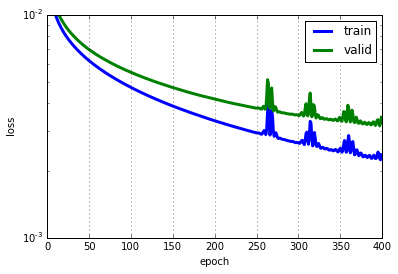

In [4]:
import cPickle as pickle
from matplotlib import pyplot
%matplotlib inline

train_loss = np.array([i["train_loss"] for i in net1.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])
pyplot.plot(train_loss, linewidth=3, label="train")
pyplot.plot(valid_loss, linewidth=3, label="valid")
pyplot.grid()
pyplot.legend()
pyplot.xlabel("epoch")
pyplot.ylabel("loss")
pyplot.ylim(1e-3, 1e-2)
pyplot.yscale("log")
pyplot.show()

We can see that our net overfits, but it's not that bad. In particular, we don't see a point where the validation error gets worse again, thus it doesn't appear that early stopping, a technique that's commonly used to avoid overfitting, would be very useful at this point. 

How do the net's predictions look like. Let's pick a few examples from the test set and check:

ImageId    1783
Image      1783
dtype: int64


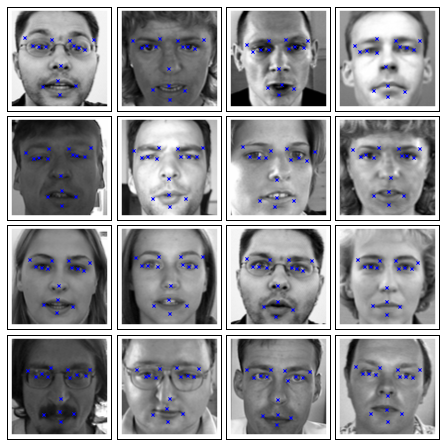

In [5]:
def plot_sample(x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

X, _ = load(test=True)
y_pred = net1.predict(X)

fig = pyplot.figure(figsize=(6, 6))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y_pred[i], ax)

pyplot.show()

# Regularization: dropout

Notice that we didn't use any regularization so far, apart from choosing a relatively small number of neurons in the hidden layer, a setting that will keep overfitting somewhat in control.

Introduced in 2012 in the Improving neural networks by preventing co-adaptation of feature detectors paper, dropout is a popular regularization technique that had been shown to work amazingly well. 

Like with any other regularization technique, dropout only makes sense if we have a network that's overfitting, which is clearly the case for our network that we trained. It's important to remember to get your net to train nicely and overfit first, then regularize.

To use dropout with Lasagne, we'll add DropoutLayer layers between the existing layers and assign dropout probabilities to each one of them.